### Импорт библиотек

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import albumentations as albu

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from preprocessing.DateCategories import balance_day_data
from datasets import DaylightDataset
from tools import train_model, IoU, pixel_accuracy
from R2AttUnet_implementation import R2AttU_Net

# torch.cuda.empty_cache()
# torch.manual_seed(41)
# np.random.seed(41)
# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed(41)

### Пути 

In [12]:
IMAGE_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/'
DAY_MASK_PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/daylight/label_'

### Подготовка данных

In [13]:
# разобьем все изображения на тренировочную, тестовую, валидационную части
X_train, X_test = train_test_split(balance_day_data, test_size = 0.065)
X_train, X_val = train_test_split(X_train, test_size = 0.118)

print('Размер X_train: {}\n'
      'Размер X_test: {}\n'
      'Размер X_val: {}'
      .format(len(X_train), len(X_test), len(X_val)))

Размер X_train: 371
Размер X_test: 30
Размер X_val: 50


### Аугментации

In [14]:
augment_1 = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.RandomRotate90(),
    albu.Transpose(),
    albu.OpticalDistortion(distort_limit=1, shift_limit=0.5),
    albu.Solarize(),
    albu.RandomGamma(),
    albu.GridDistortion()
])

### Датасеты (train, val, test)

In [19]:
train_set = DaylightDataset(img_path = IMAGE_PATH,
                               mask_path = DAY_MASK_PATH,
                               data = X_train[:370],
                               res = [4480, 224],
                               augmentation=augment_1, patching=True)
val_set = DaylightDataset(img_path = IMAGE_PATH,
                             mask_path = DAY_MASK_PATH,
                             res = [4480, 224],
                             data = X_val, patching=True)
test_set = DaylightDataset(img_path = IMAGE_PATH,
                              mask_path = DAY_MASK_PATH,
                              res = [4480, 224],
                              data = X_test)

In [21]:
# Загрузчики данных
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=2,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_set,
                              batch_size=2,
                              shuffle=False)
test_dataloader = DataLoader(dataset=test_set,
                            batch_size=1,
                            shuffle=False)

### Импорт модели, гиперпараметры

In [22]:
model = R2AttU_Net()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-3, weight_decay=1.0e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.01)
loss = torch.nn.CrossEntropyLoss()

### Обучение

In [24]:
history = train_model(model = model, N_classes = 6, model_name = 'R2AttUnet_daylight_patching',
                optimizer = optimizer, scheduler = scheduler, loss = loss,
                train_dl = train_dataloader, val_dl = val_dataloader, num_epochs = 3, patch=True)

Epoch № 1


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

train-loss: 1.8168612190195033
train-accuracy: 0.16293565837441404
train-iou: 0.046704342489874685


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:55<00:00,  9.43s/it]

validation-loss: 1.7573617267608643
validation-accuracy: 0.21958615672831633
validation-iou: 0.059658809650949864
saving model ...
Epoch № 2



 44%|█████████████████████████████████▋                                           | 81/185 [1:19:45<1:42:24, 59.08s/it]


KeyboardInterrupt: 

### Тестирование обученной модели

In [4]:
best_model_deeplab = torch.load('R2AttUnet_daylight.pth')

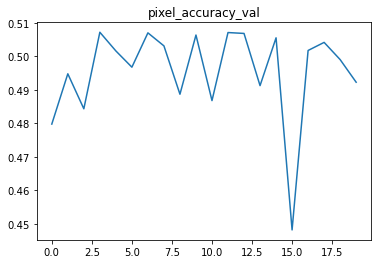

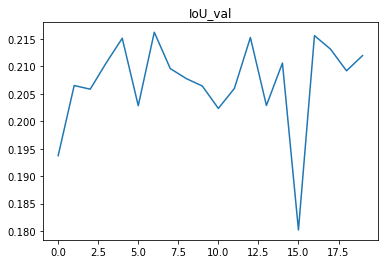

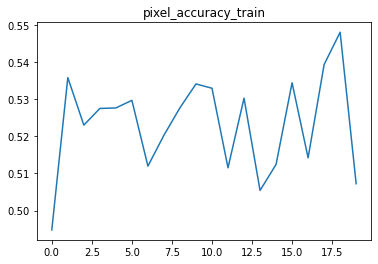

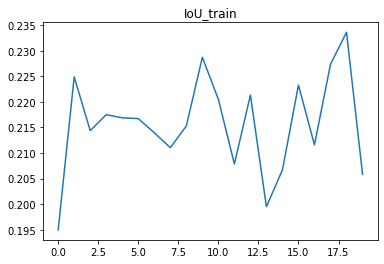

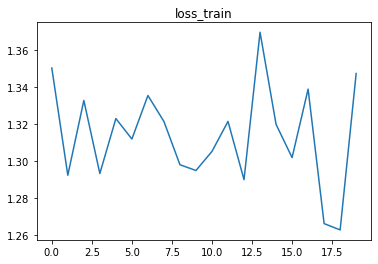

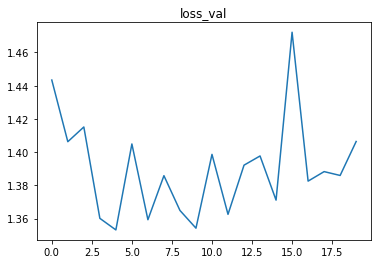

In [11]:
for key in history.keys():
    plt.plot(np.arange(10), history[key])
    plt.title(key)
    plt.pause(0.001)

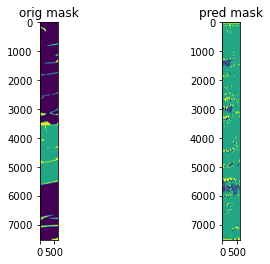

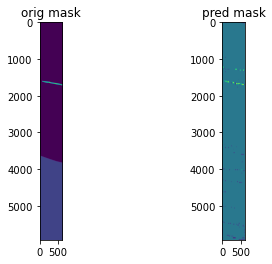

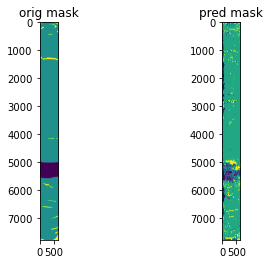

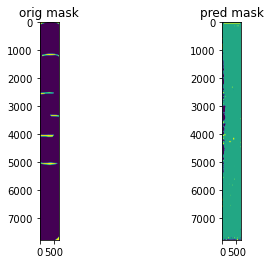

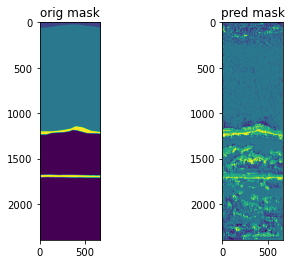

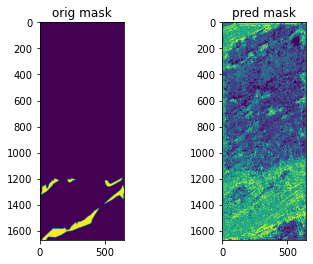

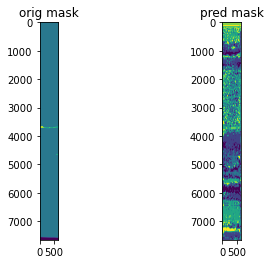

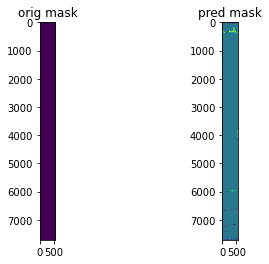

KeyboardInterrupt: 

In [5]:
from PIL import Image
from tools import prediction, model_predict
PATH = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/predict'

for id in X_test:
    img = Image.open(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/{id}.jpeg')
    pred = model_predict(best_model_deeplab, img, h_tf=256, w_tf=256)
    prediction(best_model_deeplab, img, format='day',
               path=PATH,
               img_id=str(id))
    orig_mask = np.load(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/daylight/label_{id}.npz')['x']
    ax1 = plt.subplot(121)
    plt.imshow(orig_mask)
    ax1.set_title('orig mask')
    
    ax2 = plt.subplot(122)
    plt.imshow(pred)
    ax2.set_title('pred mask')
    
    plt.pause(0.001)

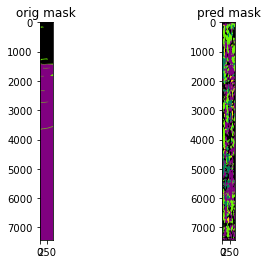

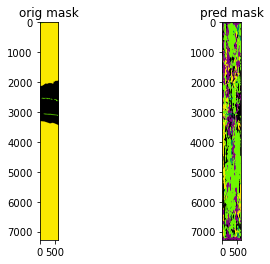

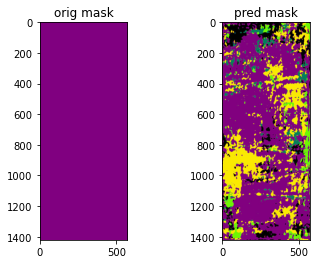

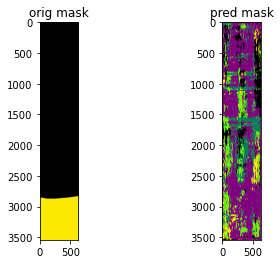

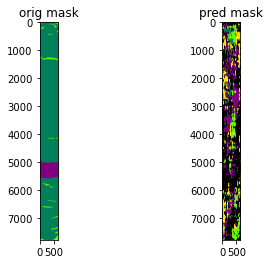

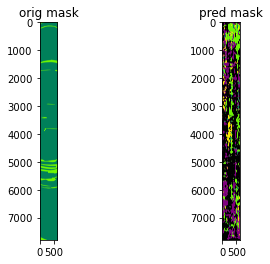

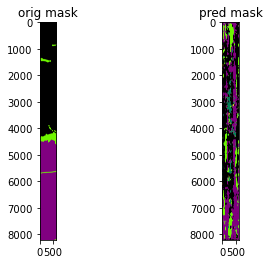

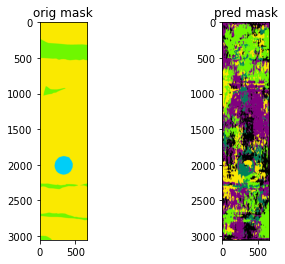

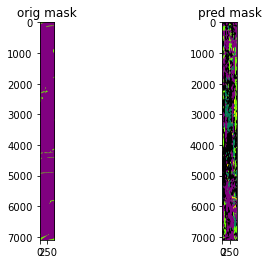

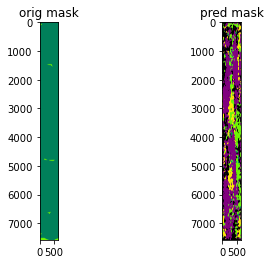

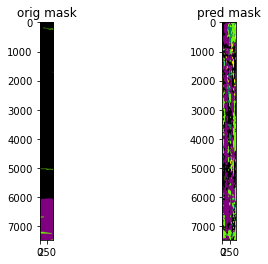

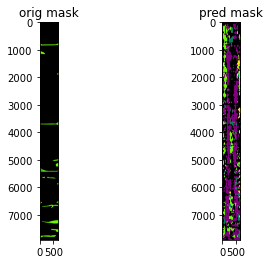

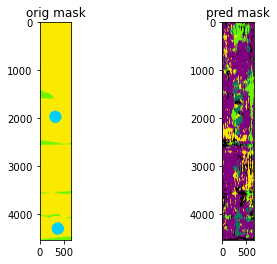

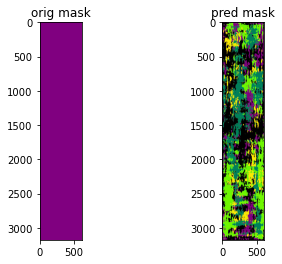

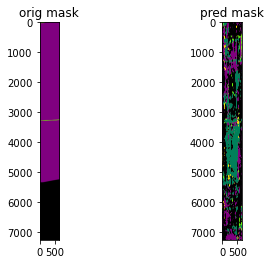

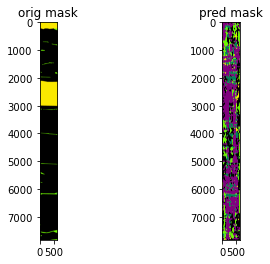

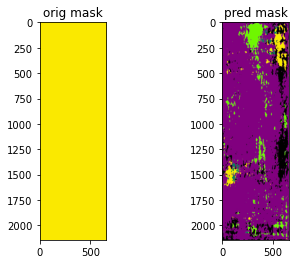

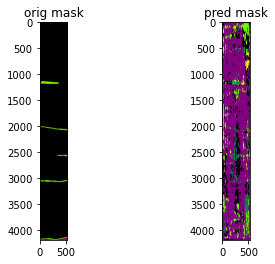

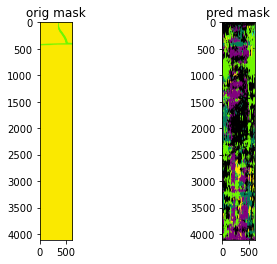

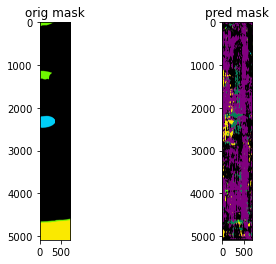

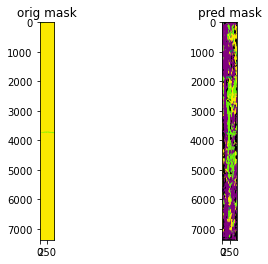

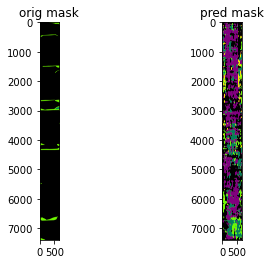

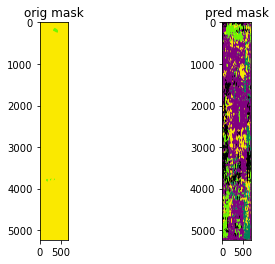

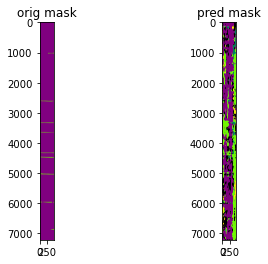

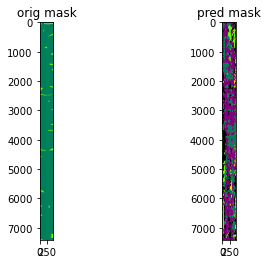

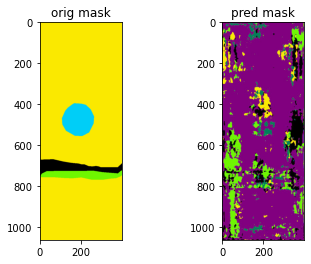

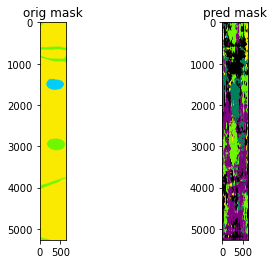

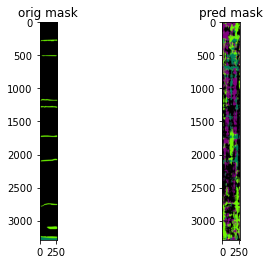

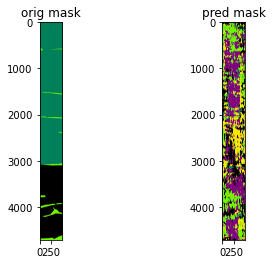

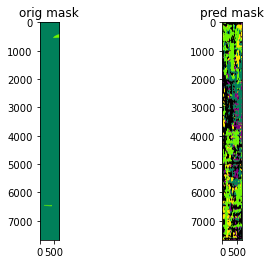

In [6]:
### mask in rgb

for id in X_test:
    orig_mask = Image.open(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels_png/daylight/label_{id}.png')
    ax1 = plt.subplot(121)
    plt.imshow(orig_mask)
    ax1.set_title('orig mask')
    
    pred = Image.open(f'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/predict/day/{id}.jpg')
    ax2 = plt.subplot(122)
    plt.imshow(pred)
    ax2.set_title('pred mask')
    
    plt.pause(0.001)